# Get SWE, Air Temp, and Precip from SNOTEL Stations
This code was adapted from scripts Amy D wrote and that were used in Reed's CEE306 course. 

- Gathers SNOTEL metadata
- Gathers SNOTEL variables SWE, Temp, and Precip from station

Notes:
- This currently is configured to only find data for one station, need to rewrite so that it gets SNOTEL data from multiple stations

In [1]:
# import libraries
from zeep import Client
from zeep import helpers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# set WSDL Client file to zeep.Client object
# this retrieves the contents of the WSDL file, which contains 'instructions'
# on what types of methods and parameters are available from this Web Service
client = Client('https://wcc.sc.egov.usda.gov/awdbWebService/services?WSDL')

The variable `client` is now an object in the zeep package. We now use different methods (provided by zeep) to act on the `client` object for various tasks, such as retriving metadata or obtaining possible measurement sites.

In [9]:
# collect list of IDs for SNOTEL and SNOTEL-LITE stations?
# .service.getStations() is a method for getting the IDs for these stations in object 'client'
snotel_sites = client.service.getStations(networkCds=['SNTL', 'SNTLT'], logicalAnd=True)
print(snotel_sites)

# remove sites from Alaska (not part of CONUS)
for s in snotel_sites:
    if s.split(":")[1] == "AK":
        snotel_sites.remove(s)

# collect site metadata for these sites
# .service.getStationMetadataMultiple is a method to collect metadata on the object 'client'
snotel_sites_metadata = client.service.getStationMetadataMultiple(snotel_sites)

# transform into Pandas DataFrame (first transform into dict)
metadata_dict = helpers.serialize_object(snotel_sites_metadata)
metadata_df = pd.DataFrame.from_dict(metadata_dict)

# truncate begin and end dates to only YYYY-MM-DD (remove time component)
metadata_df['beginDate_adj'] = metadata_df['beginDate'].apply(lambda x: x.split(" ")[0])
metadata_df['endDate_adj'] = metadata_df['endDate'].apply(lambda x: x.split(" ")[0])

metadata_df.drop(columns=['beginDate', 'endDate'], inplace=True)
metadata_df.rename(columns={'beginDate_adj': 'beginDate', 'endDate_adj': 'endDate'}, inplace=True)

# Write to .csv
metadata_df.to_csv('CopperMtn/nrcs_snotel_site_list.csv', index=False, header=True)
# We now have a .csv file, `nrcs_snotel_site_list.csv`, which lists all non-Alaska SNOTEL and SNOTEL-LITE site attribute information.

['301:CA:SNTL', '907:UT:SNTL', '916:MT:SNTL', '1267:AK:SNTL', '908:WA:SNTL', '1239:CA:SNTLT', '1198:NV:SNTLT', '1189:AK:SNTL', '1062:AK:SNTL', '1070:AK:SNTL', '302:OR:SNTL', '2065:AK:SNTL', '1000:OR:SNTL', '1245:OR:SNTLT', '303:CO:SNTL', '1030:CO:SNTL', '304:OR:SNTL', '305:CO:SNTL', '1165:MT:SNTLT', '957:AK:SNTL', '306:ID:SNTL', '1308:UT:SNTL', '307:MT:SNTL', '308:AZ:SNTL', '1140:AZ:SNTL', '1240:NV:SNTLT', '447:OR:SNTLT', '309:WY:SNTL', '310:AZ:SNTL', '311:MT:SNTL', '312:ID:SNTL', '1212:AZ:SNTL', '313:MT:SNTL', '1246:OR:SNTLT', '314:WY:SNTL', '315:MT:SNTL', '1190:MT:SNTL', '316:NM:SNTL', '1295:ID:SNTLT', '317:WY:SNTL', '318:MT:SNTL', '319:ID:SNTL', '320:ID:SNTL', '321:NV:SNTL', '1291:OR:SNTLT', '1166:OR:SNTL', '322:CO:SNTL', '323:ID:SNTL', '1061:CO:SNTL', '992:UT:SNTL', '324:ID:SNTL', '325:WY:SNTL', '326:WY:SNTL', '327:CO:SNTL', '1041:CO:SNTL', '328:MT:SNTL', '329:UT:SNTL', '330:UT:SNTL', '902:AZ:SNTL', '990:WA:SNTL', '331:OR:SNTL', '1143:AZ:SNTL', '332:UT:SNTL', '333:UT:SNTL', '334:NV

In [3]:
# define a function to get SWE based on the client, begin and end date, and station triplets
def get_snotel_swe(client, user_stationTriplets, user_beginDate, user_endDate):
    
    # get the data using zeep and the arguements given above
    instant_data_WTEQ = client.service.getData(duration='DAILY', stationTriplets=user_stationTriplets,
                                          elementCd='WTEQ', ordinal=1, beginDate=user_beginDate,
                                          endDate=user_endDate, getFlags = True)
    
    instant_data_TAVG = client.service.getData(duration='DAILY', stationTriplets=user_stationTriplets,
                                          elementCd='TAVG', ordinal=1, beginDate=user_beginDate,
                                          endDate=user_endDate, getFlags = True)
    
    instant_data_PREC = client.service.getData(duration='DAILY', stationTriplets=user_stationTriplets,
                                          elementCd='PREC', ordinal=1, beginDate=user_beginDate,
                                          endDate=user_endDate, getFlags = True)

    # convert the XML output to Python dictionary
    instant_dict_WTEQ = helpers.serialize_object(instant_data_WTEQ[0]['values'])
    instant_dict_TAVG = helpers.serialize_object(instant_data_TAVG[0]['values'])
    instant_dict_PREC = helpers.serialize_object(instant_data_PREC[0]['values'])

    # convert to Pandas DataFrame
    instant_df = pd.DataFrame.from_dict(instant_dict_WTEQ)
    instant_df['1'] = pd.Series(instant_dict_TAVG)
    instant_df['2'] = pd.Series(instant_dict_PREC)
    
    # rename columns
    instant_df.columns = ['SWE [in]', 'AirT [F]', 'PRCP [in]'] 
    
    
    
    # replace NaN values with interpolated values
    for i in range(len(instant_df)):
        if instant_df['SWE [in]'].isnull()[i]:
            instant_df['SWE [in]'][i] = instant_df['SWE [in]'][i-1]
        if instant_df['AirT [F]'].isnull()[i]:
            instant_df['AirT [F]'][i] = instant_df['AirT [F]'][i-1]
        if instant_df['PRCP [in]'].isnull()[i]:
            instant_df['PRCP [in]'][i] = instant_df['PRCP [in]'][i-1]
            
    # make type floats
    instant_df = instant_df.astype(float)

    
    # return the dataframe
    return instant_df

In [10]:
# variables to get daily data
user_beginDate = '2002-10-01'
user_endDate = '2003-09-30'
user_stationTriplets = '415:CO:SNTL'

# get the desired dataframe in one function call
swe_data = get_snotel_swe(client=client, user_stationTriplets=user_stationTriplets, 
                          user_beginDate=user_beginDate, user_endDate=user_endDate)

In [11]:
swe_data

,SWE [in],AirT [F],PRCP [in]
0,0.0,38.48,0.0
1,0.0,35.96,0.2
2,0.0,30.38,0.4
3,0.0,31.28,0.5
4,0.0,35.24,0.5
...,...,...,...
361,0.0,46.04,30.3
362,0.0,44.78,30.3
363,0.0,44.06,30.3
364,0.0,46.58,30.3


In [12]:
swe_data.to_csv('CopperMtn/SNOTEL_415-CopperMtn_SWE_WY2003.csv', header=True)

Text(0.5, 1.0, 'Precip from 2002-10-01 to 2003-09-30 at 415:CO:SNTL')

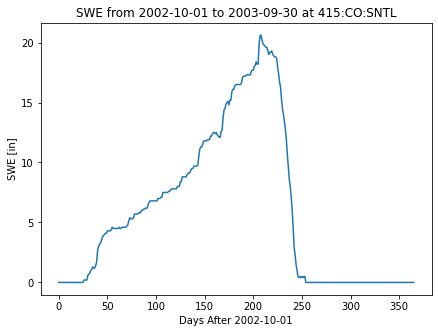

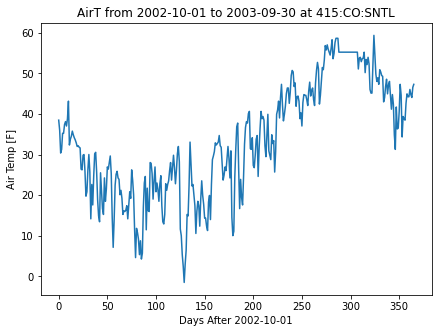

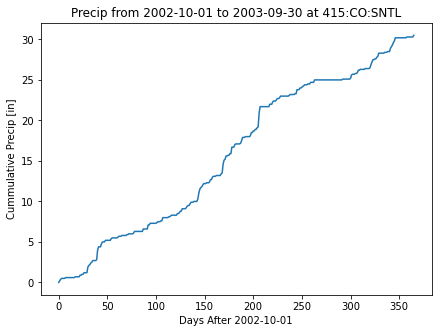

In [7]:
# plot a station (need to fix this)
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(swe_data['SWE [in]'])
ax.set_ylabel('SWE [in]')
ax.set_xlabel(f'Days After {user_beginDate}')
ax.set_title(f'SWE from {user_beginDate} to {user_endDate} at {user_stationTriplets}')

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(swe_data['AirT [F]'])
ax.set_ylabel('Air Temp [F]')
ax.set_xlabel(f'Days After {user_beginDate}')
ax.set_title(f'AirT from {user_beginDate} to {user_endDate} at {user_stationTriplets}')

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(swe_data['PRCP [in]'])
ax.set_ylabel('Cummulative Precip [in]')
ax.set_xlabel(f'Days After {user_beginDate}')
ax.set_title(f'Precip from {user_beginDate} to {user_endDate} at {user_stationTriplets}')